# Retrieve and visualize sweep results (spatial example)
In our setup, each job computes an embedding for a given method and parameter combination in isolation and send the results to wandb. There are plently of ways to visualize the results on the wandb dashbord, for example parallel coordinate plots, which help to understand paramter importance. 

However, the scIB results on wandb don't have the usual min-max column scaling that's frequently used in plots, because such scaling requires all results to be available at once, while each of our jobs only has access to a single run. Here we'll aggregate sweep results from wandb and visualize them jointly with the usual min-max column scaling. 

## Preliminaries

### Library imports

`autoreload` to re-load packages. 

In [1]:
%load_ext autoreload
%autoreload 2

The actual imports. 

In [2]:
import warnings

import matplotlib.pyplot as plt
import rapids_singlecell as rsc
import scanpy as sc
import scvi
from scembed import scIBAggregator

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

To visualze UMAPs later on, we need to original dataset

In [3]:
adata = sc.read("data/spatial_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250")
adata

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

### Preprocessing

Basic pre-processing, as in the training script. 

In [4]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Main

### Fetch runs from weights and biases (wandb)

Specify the details of your project first. 

In [32]:
agg = scIBAggregator(entity="spatial_vi", project="scembed_test_spatial_2", output_dir="top_results")
agg

INFO     Initialized scIBAggregator for spatial_vi/scembed_test_spatial_2                                          


scIBAggregator(spatial_vi/scembed_test_spatial_2, no data fetched)

Now, fetch all runs for this project, across all sweeps. 

In [33]:
agg.fetch_runs()

INFO     Fetching runs from spatial_vi/scembed_test_spatial_2...                                                   


Processing runs: 100%|██████████| 17/17 [00:00<00:00, 15470.42it/s]

INFO     Fetched 17 runs                                                                                           
INFO     Available scIB metrics: ['BRAS', 'Graph connectivity', 'Isolated labels', 'KBET', 'KMeans ARI', 'KMeans   
         NMI', 'Silhouette label', 'cLISI', 'iLISI']                                                               
INFO     Processing complete: 5 methods, 0 runs filtered out                                                       


We can now print the object again to get some more info. 

In [34]:
print(agg)

scIBAggregator(spatial_vi/scembed_test_spatial_2, 17/17 runs, 5 methods, 9 metrics, output_dir='top_results')


### Inspect individual method

First, let's look at an individual method to understand how different parameters influence performance. Method data is stored in `agg.method_data`: 

In [35]:
agg.method_data.keys()

dict_keys(['precomputed_pca', 'scanvi', 'resolvi', 'scvi', 'scviva'])

Let's take a look at this for an example method

In [38]:
method = "scvi"
agg.method_data[method].keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

The `scib_benchmarker` object can be used just like the regular scIB output: 

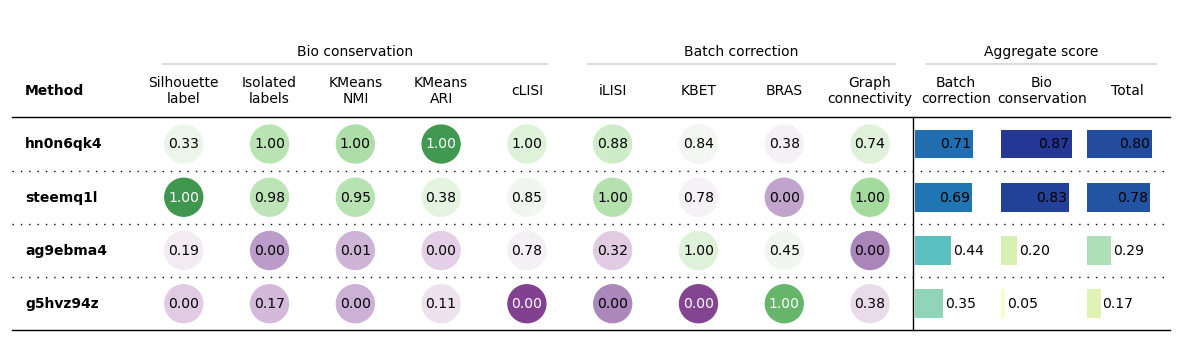

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    agg.method_data[method]["scib_benchmarker"].plot_results_table(min_max_scale=True)

The differences aren't hughe, but we can still take a look at the corresponding configs. 

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = agg.get_method_runs(method)["configs"]

res

,method,n_layers,batch_size
Embedding,,,
hn0n6qk4,scvi,1,1024
steemq1l,scvi,1,512
ag9ebma4,scvi,2,1024
g5hvz94z,scvi,2,512


This tells us which parameter set worked best for this method.  

### Aggregate results across methods

The main thing we want to get out if of course which method workes best on this dataset. For this, we call `.aggregate`, which selects the best performing run per method. 

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    agg.aggregate()

INFO     Aggregated best runs for 5 methods using metric 'Total'                                                   


Now, there's a `.results` attribute that looks just like the methods above:

In [42]:
agg.results.keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

Again, the `scib_bencharker` be be used like regular scIB output. 

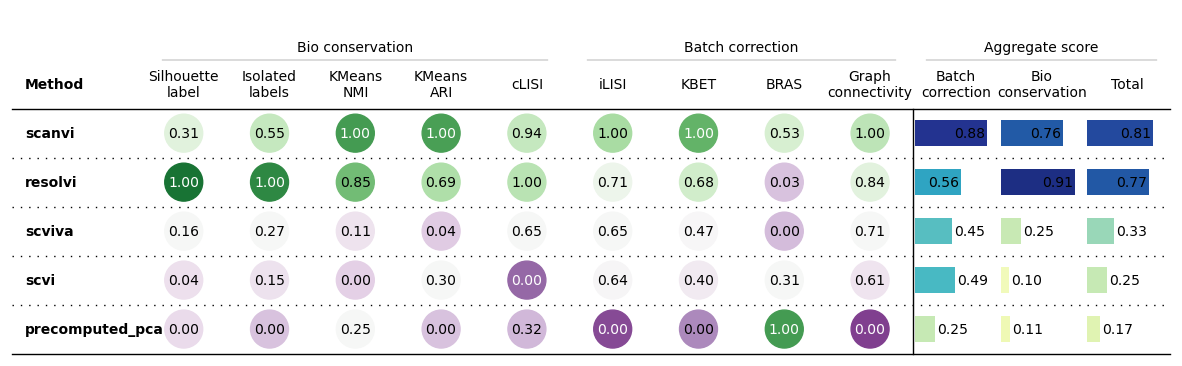

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    agg.results["scib_benchmarker"].plot_results_table(min_max_scale=True)

It looks like we have a clear winner here. Again, we can take a look at the corresponding config for each of these best performing runs. 

In [45]:
agg.results["configs"]

,run_id,embedding_key,max_epochs,n_samples_per_label,semisupervised,n_layers,batch_size,knn,embedding_method
precomputed_pca,vluya65c,X_pca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scanvi,dsrvknxy,NaN,50.0,100.0,NaN,NaN,NaN,NaN,NaN
resolvi,ijcoljhv,NaN,40.0,NaN,True,NaN,NaN,NaN,NaN
scvi,hn0n6qk4,NaN,NaN,NaN,NaN,1.0,1024.0,NaN,NaN
scviva,lhca4xqq,NaN,NaN,NaN,NaN,NaN,NaN,10.0,scanvi


We can also just get the aggregated results dataframe. 

In [46]:
agg.results["scib_benchmarker"].get_results()

,Silhouette label,Isolated labels,KMeans NMI,KMeans ARI,cLISI,iLISI,KBET,BRAS,Graph connectivity,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,
precomputed_pca,0.531647,0.529546,0.717852,0.4544,0.997652,0.200176,0.160529,0.892252,0.564943,0.454475,0.646219,0.569522
scanvi,0.558451,0.569645,0.796951,0.591811,0.999689,0.446495,0.368542,0.857527,0.923945,0.649127,0.703309,0.681636
resolvi,0.617836,0.602559,0.781191,0.548864,0.999875,0.374249,0.301627,0.820823,0.86585,0.590637,0.710065,0.662294
scvi,0.534701,0.540694,0.691897,0.495479,0.996598,0.356893,0.242852,0.841645,0.783688,0.556269,0.651874,0.613632
scviva,0.545831,0.54955,0.703933,0.46023,0.998739,0.359079,0.257809,0.818935,0.818594,0.563604,0.651657,0.616436
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


### Retrieve embeddings

For each best-performing model, let's download the model weights (if available) and the embedding to a local folder. 

In [47]:
agg.get_models_and_embeddings()

WARNING  No artifacts found for method 'precomputed_pca' (run_id: vluya65c)                                        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models for method 'scanvi' to top_results/scanvi/                                              
WARNING  Missing embedding for method 'scanvi' (run_id: dsrvknxy)                                                  


wandb:   1 of 1 files downloaded.  


INFO     Downloaded models for method 'resolvi' to top_results/resolvi/                                            
WARNING  Missing embedding for method 'resolvi' (run_id: ijcoljhv)                                                 


wandb:   1 of 1 files downloaded.  


INFO     Downloaded models for method 'scvi' to top_results/scvi/                                                  
WARNING  Missing embedding for method 'scvi' (run_id: hn0n6qk4)                                                    


wandb:   1 of 1 files downloaded.  


INFO     Downloaded models for method 'scviva' to top_results/scviva/                                              
WARNING  Missing embedding for method 'scviva' (run_id: lhca4xqq)                                                  


Load each model, retrieve the latent representation, get a umap, and visualize jointly. We omit scVIVA here, as the setup is a bit more complicated. 

In [51]:
model_dict = {
    "scvi": scvi.model.SCVI.load("top_results/scvi/models", adata=adata),
    "scanvi": scvi.model.SCANVI.load("top_results/scanvi/models", adata=adata),
    "resolvi": scvi.external.RESOLVI.load("top_results/resolvi/models", adata=adata),
}

INFO     File top_results/scvi/models/model.pt already downloaded                                                  
INFO     File top_results/scanvi/models/model.pt already downloaded                                                
INFO     File top_results/resolvi/models/model.pt already downloaded                                               


/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to

RAPIDS SingleCell is installed and can be imported
RAPIDS SingleCell is installed and can be imported
RAPIDS SingleCell is installed and can be imported


/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightni

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:03, 14.21it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/50:   2%|▏         | 1/50 [00:00<00:03, 13.74it/s, v_num=1]


/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/train/_trainrunner.py:122: UserWarning: Training history cannot be updated. Logger can be accessed from `model.trainer.logger`
  self._update_history()


In [52]:
for key, model in model_dict.items():
    adata.obsm[f"X_{key}"] = model.get_latent_representation()

    rsc.pp.neighbors(adata, use_rep=f"X_{key}")
    rsc.tl.umap(adata, key_added=f"umap_{key}")

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...


Now, let's take a look at these. 

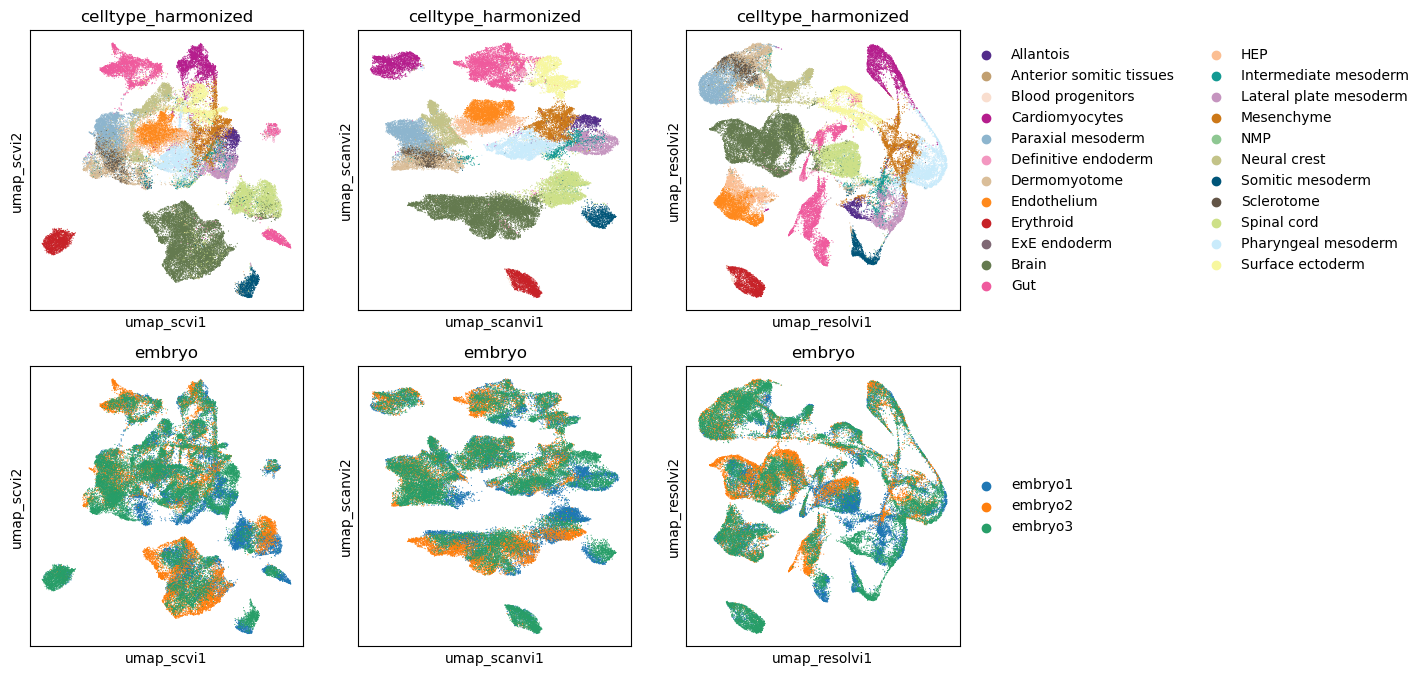

In [59]:
keys = model_dict.keys()
fix, axes = plt.subplots(2, len(keys), figsize=(4 * len(keys), 8))

for i, key in enumerate(keys):
    shared_params = {
        "basis": f"umap_{key}",
        "show": False,
        "legend_loc": "right margin" if i == len(keys) - 1 else "none",
    }
    sc.pl.embedding(adata, color="celltype_harmonized", ax=axes[0, i], **shared_params)
    sc.pl.embedding(adata, color="embryo", ax=axes[1, i], **shared_params)

plt.show()